# Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The dataset can be read from the web to R as follows:

In [9]:
htru_data <- read_csv(
    "https://github.com/Bruce0517/dsci-100-2022w1-group-160/raw/main/HTRU_2.csv", 
    col_names = c("p.mean", "p.sd", "p.kurt", "p.skew",
                  "c.mean", "c.sd", "c.kurt", "c.skew", "class"))|>
    mutate(class = as_factor(class))


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): p.mean, p.sd, p.kurt, p.skew, c.mean, c.sd, c.kurt, c.skew, class

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The data describes some kind of distribution describing the data gathered from pulsar candidates. A 0 in the class column indicates that the observation is not a pulsar, while a 1 indicates that it is a pulsar. Here is a sample of some non-pulsars:

In [10]:
set.seed(69420)
sample_n(filter(htru_data, class == 0), 3)

p.mean,p.sd,p.kurt,p.skew,c.mean,c.sd,c.kurt,c.skew,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
100.1484,41.15787,0.6187296,1.5244102,1.732441,16.48696,12.498927,168.368092,0
110.1641,40.31318,0.5820537,0.7071917,3.343645,18.43795,8.038802,81.182894,0
131.1797,48.99863,0.0702603,-0.1755943,14.413880,43.49945,3.073368,8.639341,0


And here is a sample of some pulsars:

In [11]:
set.seed(69420)
sample_n(filter(htru_data, class == 1), 3)

p.mean,p.sd,p.kurt,p.skew,c.mean,c.sd,c.kurt,c.skew,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28.96875,43.76017,3.737043,13.45894,71.34783,72.43619,0.6679135,-0.5201263,1
52.26562,38.12674,2.870491,10.72618,31.28344,61.65925,1.9183272,2.6605270,1
17.43750,28.46784,6.776965,48.40095,71.68562,55.56210,1.5013040,2.0250674,1


Then, we shall separate the data into training and testing sets:

In [12]:
set.seed(69420)

htru_split <- initial_split(htru_data, prop = .8, strata = class)  
htru_train <- training(htru_split)   
htru_test <- testing(htru_split)

Here is the number of members of each class in the training data, as well as the average value for each of the variables:

In [13]:
htru_train |>
    group_by(class) |>
    summarize(n = n(), p.mean = mean(p.mean), p.sd = mean(p.sd), p.kurt = mean(p.kurt), p.skew = mean(p.skew),
                       c.mean = mean(c.mean), c.sd = mean(c.sd), c.kurt = mean(c.kurt), c.skew = mean(c.skew))

class,n,p.mean,p.sd,p.kurt,p.skew,c.mean,c.sd,c.kurt,c.skew
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,13025,116.6215,47.33444,0.2090326,0.3782325,8.880065,23.30449,8.862873,113.8671
1,1293,56.6905,38.68421,3.1440269,15.7029792,50.746641,56.75291,2.693285,17.2914


It should be noted that this data set did not require the "na.rm = TRUE" argument, this indicates that there are no missing values that must excluded from the data. The following is a histogram for each of these values from a sample of 1000 pulsars and 1000 non-pulsars, to compare the distributions of the predictor variables:

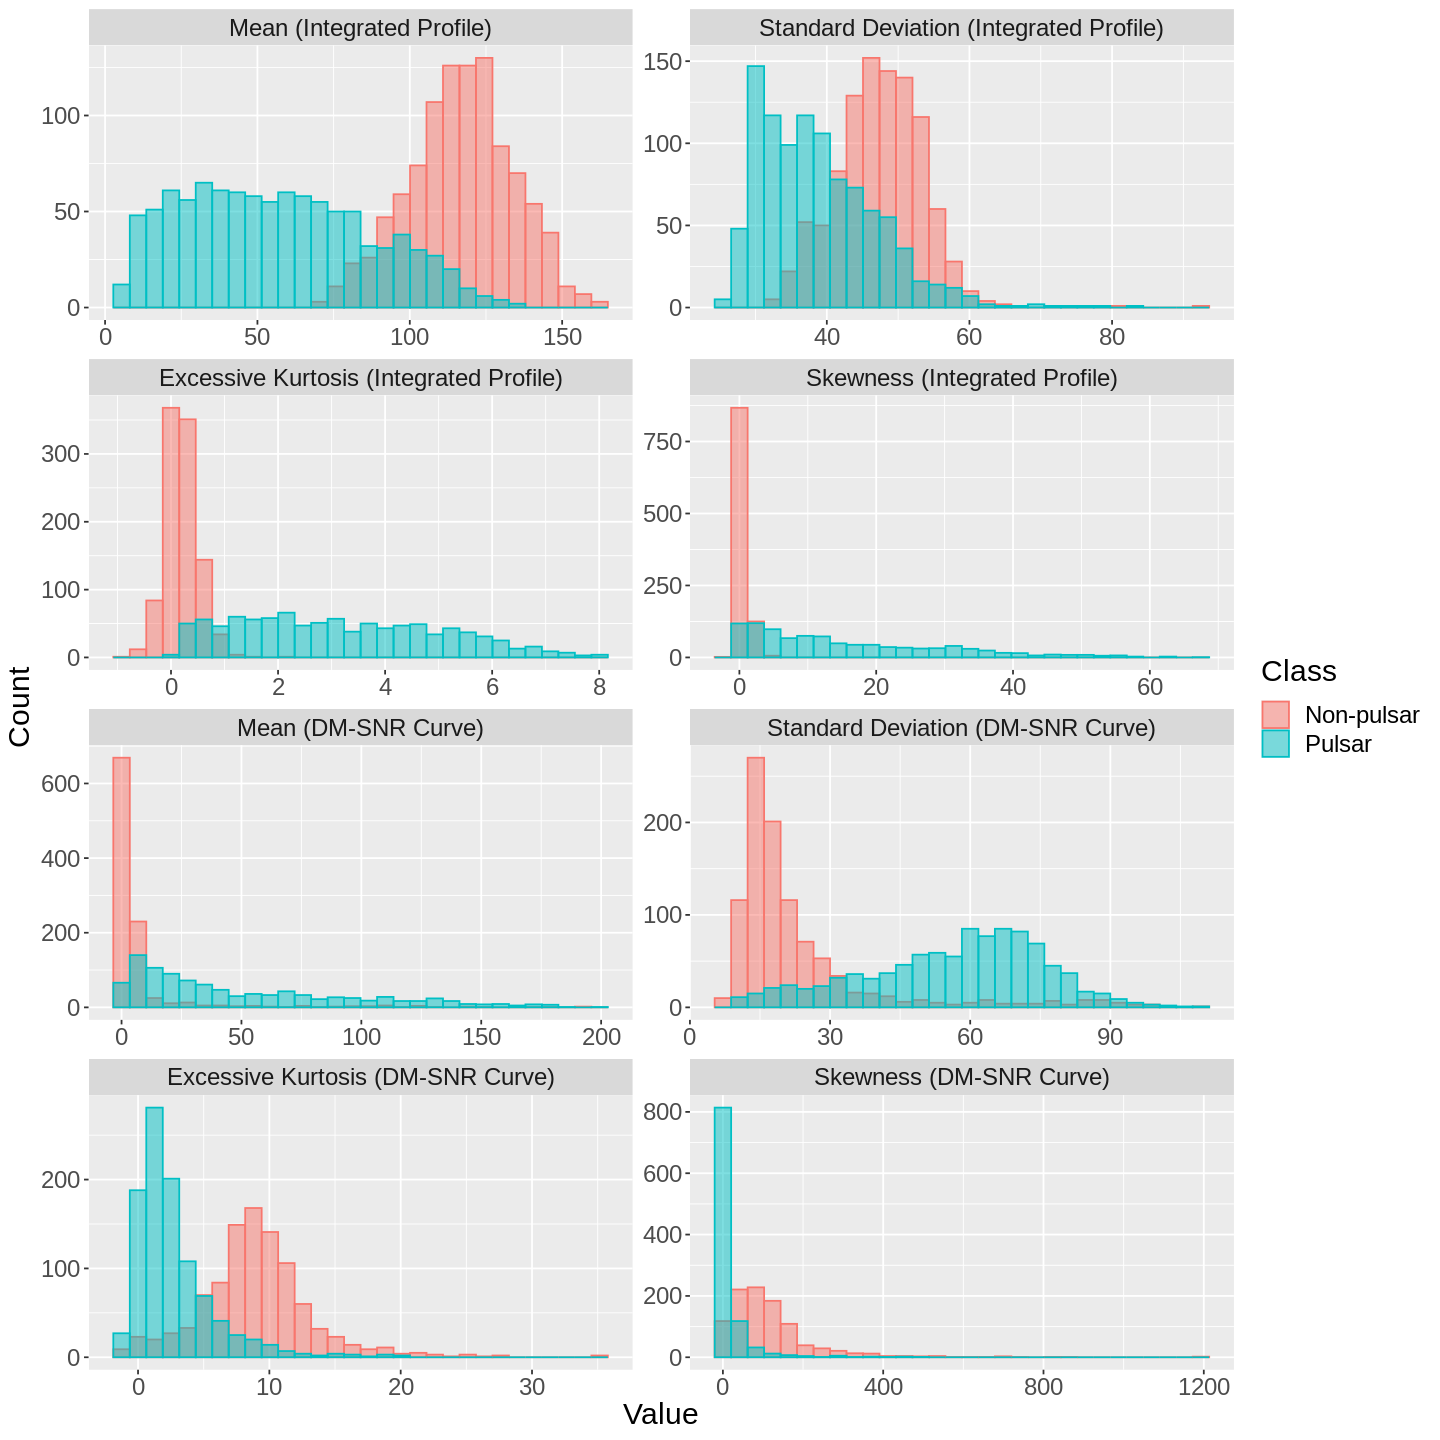

In [14]:
options(repr.plot.width=12, repr.plot.height=12)
set.seed(69420)

factor_levels <- c("p.mean", "p.sd", "p.kurt", "p.skew", "c.mean", "c.sd", "c.kurt", "c.skew")
pulsar_sample <- filter(htru_train, class == 1) |>
                     sample_n(1000) |>
                     # To plot the data we must first untidy the data
                     pivot_longer(-class, names_to = "preds", values_to = "vals") |>
                     mutate(preds = factor(preds, levels = factor_levels))
non_pulsar_sample <- filter(htru_train, class == 0) |>
                     sample_n(1000) |>
                     # To plot the data we must first untidy the data
                     pivot_longer(-class, names_to = "preds", values_to = "vals") |> 
                     mutate(preds = factor(preds, levels = factor_levels))
histo_data <- bind_rows(pulsar_sample, non_pulsar_sample)
facet_labels <- c("p.mean" = "Mean (Integrated Profile)", 
                  "p.sd" = "Standard Deviation (Integrated Profile)", 
                  "p.kurt" = "Excessive Kurtosis (Integrated Profile)", 
                  "p.skew" = "Skewness (Integrated Profile)",
                  "c.mean" = "Mean (DM-SNR Curve)", 
                  "c.sd" = "Standard Deviation (DM-SNR Curve)", 
                  "c.kurt" = "Excessive Kurtosis (DM-SNR Curve)", 
                  "c.skew" = "Skewness (DM-SNR Curve)")

ggplot(histo_data, aes(x = vals, fill = as_factor(class), color = as_factor(class))) +
    geom_histogram(alpha = 0.5, position = "identity", bins = 30) +
    facet_wrap(vars(preds), nrow = 4, ncol = 2,
               scales = "free", 
               labeller = as_labeller(facet_labels)) +
    labs(x = "Value", y = "Count", fill = "Class", color = "Class") +
    scale_fill_discrete(labels = c("Non-pulsar", "Pulsar")) +
    scale_color_discrete(labels = c("Non-pulsar", "Pulsar")) +
    theme(text = element_text(size=18))

The plots show that most values do not have a significant overlap for pulsars and non-pulsars, and thus all of them would be useful for data analysis.